# **Sentiment Analysis Using Gated-Recurrent Neural Networks**

In [1]:
__author__ = "Mohamad Radwan"
__email__ = "mohrad96@hotmail.com"

In this project, we will use the IMDB dataset that contains the text of 50,000 movie reviews from the Internet Movie Database (IMDB) website. The label of each movie review is either positive or negative. An example of the input-output pair in this dataset is

"*I happen to run into this movie one night so I decided to watch it ! I was very pleased with the movie ... I thought it was a wonderful plot . It 's a great feeling knowing a deceased one has come back and you get that second chance to say what you want to say ! And this wife stayed devoted for 23 years ! ! ! I thought it was a great movie ! !*"

where its label, as you might expect, is 
"*positive*".

**In this project, we want to design a classifier that takes as input a review and outputs whether it is a positive or negative review about a movie.**

In the next two cells, we import some modules and also fix some constants for our implementation. 

In [2]:
import csv
from typing import Callable, Tuple

import jax.numpy as jn
import matplotlib.pyplot as plt
import numpy as np
from jax import lax
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tqdm import trange
from sklearn.model_selection import train_test_split
%pip --quiet install objax
import objax
from objax.typing import JaxArray


objax.random.DEFAULT_GENERATOR.seed(42)
np.random.seed(42)

     |████████████████████████████████| 51kB 4.3MB/s 


In [3]:
!gdown --id 11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7

Downloading...
From: https://drive.google.com/uc?id=11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7
To: /content/IMDB Dataset.csv
66.2MB [00:00, 72.4MB/s]


In [4]:
max_vocab = 2000  # this parameter is for the maximum number of words in the "dictionary"
max_len = 200  # maximum length of each review
embedding_size = 30  # size of embedding
num_hidden_units_GRU = 30  # GRU cells in the RNN layer
num_hidden_units = 60  # hidden unit of dense network after GRU

vocab_size = max_vocab
filename = 'IMDB Dataset.csv'

## How to find a representation of sentences?
In order to put the words into the machine learning algorithm the text data should be converted into a vector representation. The first approach that comes to mind is *one hot encoding*.
 # One Hot Encoding
Assume that we count the number of english words in the Merriam-Webster dictionary, and it turns out that the total number of words is $N$. Then, a possible way to represent the words is to use binary vectors of size $N$. Each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a $1$.
As an example let's say all the words in the dictionary consists of $\{$apple, orange, Milan,Rome$\}$. For this example, the one hot encoding is given by:
 
apple = $[1,0,0,0]$ \\
orange = $[0,1,0,0]$ \\
Milan = $[0,0,1,0]$  \\
Rome = $[0,0,0,1]$
 
We can also represent each word by an integer: for instance in the above-mentioned example, the mapping is apple $\rightarrow$ 1, orange $\rightarrow$ 2, Milan $\rightarrow$ 3,  Rome $\rightarrow$ 4.
 



When we are working with a dataset, a practical approach for one-hot encoding of the data is as follows:
 
1.  First, we can create a dictionary which shows each word along with its frequency in the dataset. For example, if the sentence is "Put the books on the table." , we need to create a dictionary such that word_index["Put"] = 1; word_index["the"] = 2; word_index["books"] = 1; word_index["on"] = 1; word_index["table"] = 1.
2.  Second, based on the maximum size of the vocabulary we want, we can sort the words based on their frequency and only pick the most frequent words of this maximum size of the vocabulary, and this creates our dictionary. So lower integer means more frequent word (often the first few are stop words because they appear a lot)
 
3. Then, we can assign an integer to each word in the dictionary, and represent each sentence as a sequence of integers.
 
 
The following function performs the above-mentioned steps for our IMDB dataset.



In [5]:
def data_processing(filename, max_vocab, max_len):
  # filename: the name of the .csv file
  # max_vocab: The maximum number of words
  # max_len: maximum length of each review
  messages = []  # a list contains the reviews
  labels = []  # a list contains the labels
  with open(filename, 'r') as file:
      reader = csv.reader(file)
      firstline = True
      for row in reader:
        if firstline:
            firstline = False
            continue
        else:
            messages.append(row[0])
            labels.append(int(row[1]=='positive'))

  tokenizer = Tokenizer(num_words=max_vocab)
  tokenizer.fit_on_texts(messages)
  messages_seq = tokenizer.texts_to_sequences(messages)
  data = pad_sequences(messages_seq, maxlen=max_len)  
  train_size = 0.8
  messages_train, messages_valid_test, labels_train, labels_valid_test  = train_test_split(data, labels, train_size=train_size)
  messages_valid, messages_test, labels_valid, labels_test  = train_test_split(messages_valid_test, labels_valid_test, train_size=0.5)
  return np.array(messages_train), np.array(labels_train), np.array(messages_valid), np.array(labels_valid), np.array(messages_test), np.array(labels_test)

For the data_processing function, we used Tokenizer which is a class in keras.preprocessing.text.



**"fit_on_texts"** uses word frequency to create a list of indices of the most frequent words in the dataset that is passed as its input(with the most frequent word having an index of 1 because 0 is reserved for padding purposes). Since max_vocab was passed to Tokenizer as num_words argument, the list of indices will consist of max_vocab-1(2000-1=1999) indices which are the indices of the 1999 most frequent words in the dataset, where the indices in this case range from 1(most frequent) to 1999(least frequent).

**"texts_to_sequences"**  takes as input the list of sentences to be transformed into a list of sequences of integers(which are obtained by cross-referencing with the word indices generated by "fit_on_texts"). If a certain word is not found in the list of indices then it will be simply skipped and not assigned an integer.

messages_seq is now a list of lists of integers, however, each one of these lists is of different size due to having different lengths of reviews, so to create a matrix that has a specified number of columns, we use **"pad_sequences"** which adds zeros at the beginning of each list until the maxlen(200 in this case) is achieved, so the output in this case has dimensions of (number of reviews, 200). Moreover, if a certain list has a length greater than max_len, then the last max_len elements of that list are kept. We need "pad_sequences" because we need a consistent number of features for every input.

In the next cell, we encode the data set using one-hot encoding, and split the dataset into the training set, validation set, and the test test.

In [6]:
messages_train, labels_train, messages_valid, labels_valid, messages_test, labels_test = data_processing(filename, max_vocab, max_len)

We check that the input is indeed the way we want it to be.

In [7]:
print("Fourth input:\n",messages_train[3], "\n Length: ",len(messages_train[3]))

Fourth input:
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0   11 1601  254    6    3  456 1925   16   32   35 1094  396    5
  969  122   24  123   31   47    4    1   22   80  123  125  519   20
    2   35   39  582    5   26    1  227   81    5    3  171 1738  806
   60   61  946    8   47  965 1195    3   60  508  776  271   32 1313
 1843 1414   35  508  542 1188  506   21    5  747    3  768  722   41
    4    1 1426    4  259    8   11  417    1  105 1783 1533    8    1
  127   10  185  131  145  760   12   11   19  276   54    4    1    4
   15    1   60    9    8  440  767    2   12    9    6 1467    5 1575
   53    1   18  619   96 1091  286    4    2   38 1457   16  

As expected, each input in the training set is a list of integers ranging from 0 to 1999(padded by zeros at the start if the original list had less than 200 elements).

## Embedding Layer



Imagine that we have 80,000 unique words in a text classification problem and we select to preprocess the text as explained above. For instance, a sentence "i love you" or ['i', 'love', 'you'] can be shown as a matrix of size (3 , 80000) where its elements is all zeros except from 3 elements that correspond to those words. In the case that we want to extract the feature using recurrent neural netowk, the input size should be the size of $80,000$ in which only three entries are non-zero!

Instead, we can use the observation that since our goal is to extract feature from a sentence, we might be able to construct a mapping so that the words whose meanings are similar map to the same vector. One possible approach to do this is to perform this maaping using a simple matrix multiplication that transforms words into their corresponding word embeddings or turns positive integers (indexes) into dense vectors of fixed size, where the size of embedding $\ll$ size of the vocabualry. 


Since Objax does not have embedding layer module in it, we need to write our own module. One implementation of the embedding layer is as follows. 

In [8]:
class Embed(objax.Module):
    def __init__(self, size: int, latent: int, init: Callable = objax.nn.init.xavier_truncated_normal):
        self.w = objax.TrainVar(init((size, latent)))

    def __call__(self, x: JaxArray) -> JaxArray:
        return self.w.value[x]

"__init__":defines a weight matrix(trainable variables) of shape (size, latent) initialized with values according to objax.nn.init.xavier_truncated_normal. This is only done when the class is instantiated.

"__call__": when its input x is a sentence, then each element in x acts as a row index for the weight matrix w, so the sentence is transformed into an embedding with dimensions (max_len, latent).

## Gated Recurrent Unit Cell
GRUs are a family of the recurrent neural networks used for processing of the sequential data. In this project, we want to use GRU for the sentiment analysis.

The forward pass of a Gated Recurrent Unit is defined by the following equations:




1.   $z_t = \text{sigmoid} (W_z x_t + U_z h_{t-1} + b_z)$
2.   $r_t = \text{sigmoid} (W_r x_t + U_r h_{t-1} + b_r)$
3.   $\hat{h}_t = \text{tanh} (W_h x_t + U_h (r_t \odot h_{t-1}) + b_h)$
4.   $h_t =  (1-z_t)\odot h_{t-1} + z_t \odot \hat{h}_t$

where
the operator ${\displaystyle \odot }$  denotes the Hadamard product, and 

*  $x_{t}$: input vector
*   $h_{t}$: output vector
* ${\hat {h}}_{t}$: candidate activation vector
* $z_{t}$: update gate vector
* $r_{t}$: reset gate vector
* $W_z$, $W_r$, $W_h$ , $U_z$, $U_r$, $U_h$, $b_z$ ,$b_r$, $b_h$ are parameter matrices and vectors.







The schematic of a GRU cell is show below (taken from Wikipedia). Here $\hat{y}_t$ is the same as $h_t$, and $\sigma$ is sigmoid function.

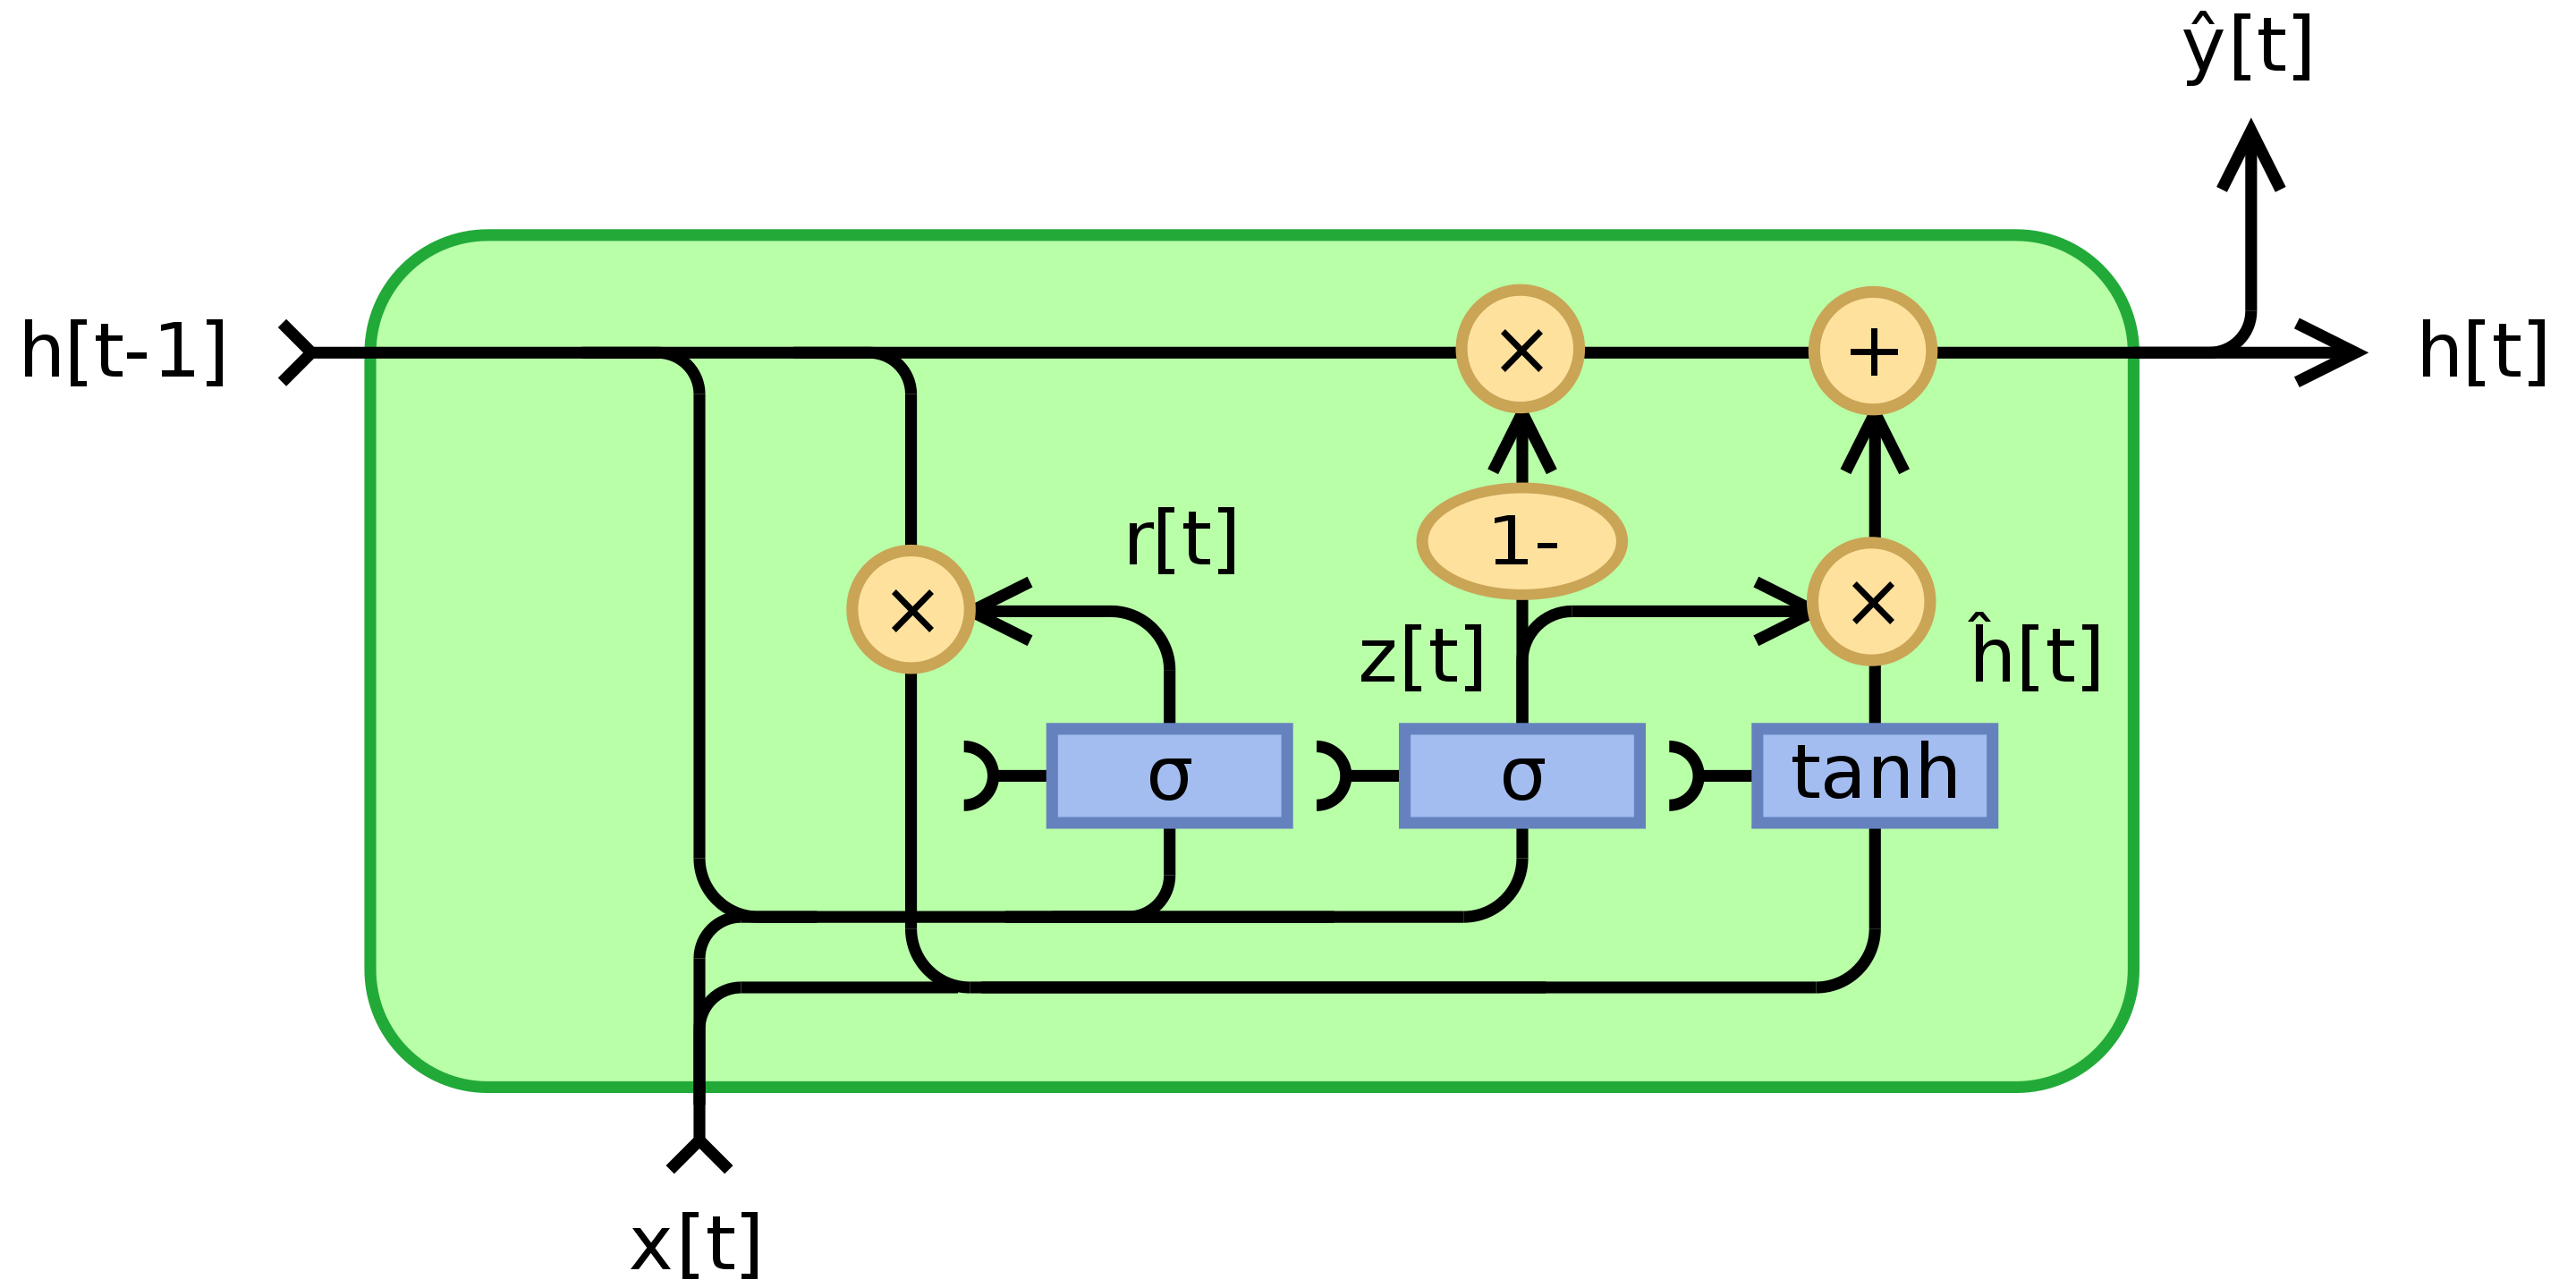

Similar to the embedding layer, GRU module is not implemented in the Objax. The following is an implementation of the GRU cell in the Objax.

In [9]:
class GRU(objax.Module):
    def __init__(self, nin: int, nout: int,
                 init_w: Callable = objax.nn.init.xavier_truncated_normal,
                 init_b: Callable = objax.nn.init.truncated_normal):
        self.update_w = objax.TrainVar(init_w((nin, nout)))
        self.update_u = objax.TrainVar(init_w((nout, nout)))
        self.update_b = objax.TrainVar(init_b((nout,), stddev=0.01))
        self.reset_w = objax.TrainVar(init_w((nin, nout)))
        self.reset_u = objax.TrainVar(init_w((nout, nout)))
        self.reset_b = objax.TrainVar(init_b((nout,), stddev=0.01))
        self.output_w = objax.TrainVar(init_w((nin, nout)))
        self.output_u = objax.TrainVar(init_w((nout, nout)))
        self.output_b = objax.TrainVar(init_b((nout,), stddev=0.01))

    def __call__(self, x: JaxArray, initial_state: JaxArray) -> Tuple[JaxArray, JaxArray]:
        def scan_op(state: JaxArray, x: JaxArray) -> JaxArray:  # State must come first for lax.scan
            
            update_gate = 1/(1+jn.exp(-(jn.dot(x,self.update_w.value) + jn.dot(state,self.update_u.value) + self.update_b.value)))

            
            reset_gate = 1/(1+jn.exp(-(jn.dot(x,self.reset_w.value) + jn.dot(state,self.reset_u.value) + self.reset_b.value)))
            
            
            output_gate =  jn.tanh(jn.dot(x,self.output_w.value) + jn.dot(reset_gate*state,self.output_u.value) + self.output_b.value)
            
            
            return (1-update_gate) * state + (update_gate) * output_gate, 0   # we don't use the output, return 0.

        return lax.scan(scan_op, initial_state, x.transpose((1, 0, 2)))[0]

**"lax.scan"** function takes as input the function scan_op which is the function that it should loop through 200 times since we have 200 word representations per sentence (200 time steps). It also takes as input the initial state which it updates each loop and carries it over to the next loop or time step. Its third argument is the data it should loop over which is x having dimensions of (batch_size,max_len,embedding_size), it loops over the first axis of the passed data, that is why we pass it x.transpose((1, 0, 2)) since we want it to loop over the 2nd dimension of x which is the max_len(200) which is the number of word representations per sentence (200 time steps), so in each loop (batch_size, embedding_size) elements of x are involved in the computations of the gates which allows us to get the next state. Example: 

In [10]:
embedded = Embed(size = max_vocab, latent = embedding_size)
output_embedded = embedded(messages_train[0:250])  #batch size = 250
print("Embedding Layer Input Shape:", messages_train[0:250].shape)
print("Embedding Layer Output Shape:", output_embedded.shape)
print("Passed Input Argument Shape to lax.scan:", output_embedded.transpose((1,0,2)).shape)
gatedLayer = GRU(nin = embedding_size, nout = num_hidden_units_GRU)
output_gated = gatedLayer(x = output_embedded, initial_state=jn.zeros((output_embedded.shape[0], num_hidden_units_GRU)))
print("Output shape of lax.scan:", output_gated.shape)

Embedding Layer Input Shape: (250, 200)
Embedding Layer Output Shape: (250, 200, 30)
Passed Input Argument Shape to lax.scan: (200, 250, 30)
Output shape of lax.scan: (250, 30)


So, lax.scan is useful for updating the state over the different time steps while looping over the first dimension of the passed data argument.

## The classifier 

The structure of the proposed classifier is as follows:


*   The input is a vector whose elements are integers in the interval $\{$1,...,max_vocab$\}$ of length max_len. In fact input is the one-hot encoding of each review.
*    Then, the embedding layer converts this vector into a matrix of size (max_len,embedding_size).
* Then, we feed each row of this matrix into the GRU cell. The size of the output vector of the GRU is num_hidden_units_GRU.
*  The output of the GRU is feed into a fully-connected layer with num_hidden_units neurons and ReLU activation function.

* Finally, we have the output layer which is a fully-connected layer with two outputs corresponding to the positive or negative label.



In [11]:
gru_rnn = objax.nn.Sequential([Embed(size = max_vocab, latent = embedding_size), GRU(nin = embedding_size, nout = num_hidden_units_GRU)
    
, objax.nn.Linear(num_hidden_units_GRU, num_hidden_units), objax.functional.relu, objax.nn.Linear(num_hidden_units, 2)])

Next, we print the structure as well as the number of the parameters of the each layer using the following line of codes.

In [12]:
print(f'{" Network ":-^79}')
print(gru_rnn.vars())

----------------------------------- Network -----------------------------------
(Sequential)[0](Embed).w         60000 (2000, 30)
(Sequential)[1](GRU).update_w      900 (30, 30)
(Sequential)[1](GRU).update_u      900 (30, 30)
(Sequential)[1](GRU).update_b       30 (30,)
(Sequential)[1](GRU).reset_w       900 (30, 30)
(Sequential)[1](GRU).reset_u       900 (30, 30)
(Sequential)[1](GRU).reset_b        30 (30,)
(Sequential)[1](GRU).output_w      900 (30, 30)
(Sequential)[1](GRU).output_u      900 (30, 30)
(Sequential)[1](GRU).output_b       30 (30,)
(Sequential)[2](Linear).b           60 (60,)
(Sequential)[2](Linear).w         1800 (30, 60)
(Sequential)[4](Linear).b            2 (2,)
(Sequential)[4](Linear).w          120 (60, 2)
+Total(14)                       67472


Constructing an SGD optimizer using objax optimizers package.

In [13]:
opt = objax.optimizer.SGD(gru_rnn.vars())

Then, we define the loss function, training operation function, and the
evaluation function.

In [14]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv = objax.GradValues(loss_function, gru_rnn.vars())


@objax.Function.with_vars(gv.vars() + opt.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv(x, y)
    opt(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn.vars())

The next function is a helper for computing the accuracy.

In [15]:
def accuracy(data_loader):
    """Compute the accuracy for a provided data loader"""
    acc_total = 0
    x, y = data_loader
    batch_size_acc = 500
    for batch_idx in np.array_split(np.arange(len(x)), len(x) // batch_size_acc):
        x_batch, target_class = x[batch_idx], y[batch_idx]
        predicted_class = eval_op(x_batch).argmax(1)
        acc_total += (predicted_class == target_class).sum()
    return acc_total / len(x)

In [16]:
learning_rate = 1e-3 # learning rate
num_epochs = 20 # number of epochs
batch_size = 250  # batch size
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [17]:
# training loop

train_acc_epoch = []
val_acc_epoch = []

for epoch in range(num_epochs):
    avg_train_loss = 0 # (averaged) training loss per batch

    # shuffle the examples prior to training to remove correlation 
    train_indices = np.arange(len(messages_train)) 
    np.random.shuffle(train_indices)
    for it in range(0, messages_train.shape[0], batch_size):
        batch = train_indices[it:(it+np.minimum(batch_size,messages_train.shape[0]-it))]
        avg_train_loss += float(train_op(messages_train[batch], labels_train[batch], learning_rate)[0]) * len(batch)
    
    train_acc_epoch.append(100*accuracy(training_data))
    val_acc_epoch.append(100*accuracy(validation_data))

test_accuracy = 100*accuracy(test_data)
print("SGD Test Accuracy:", test_accuracy," %")

SGD Test Accuracy: 85.1  %


SGD optimizer: Max Validation Accuracy:  84.740005 % at epoch  20


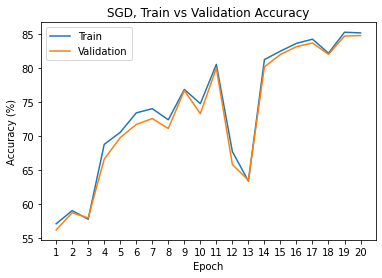

SGD Test Accuracy: 85.1  %
Generalization Gap between Validation and Training: 0.38500214 %
Generalization Gap between Test and Training: 0.025009155 %


In [18]:
print("SGD optimizer: Max Validation Accuracy: ",round(max(val_acc_epoch),3),"% at epoch ", val_acc_epoch.index(max(val_acc_epoch))+1)

plt.title("SGD, Train vs Validation Accuracy")
plt.plot(range(1,len(val_acc_epoch)+1),train_acc_epoch, label="Train")
plt.plot(range(1,len(val_acc_epoch)+1),val_acc_epoch, label="Validation")
plt.xticks(list(range(1,len(val_acc_epoch)+1)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(loc='best')
plt.show()

print("SGD Test Accuracy:", test_accuracy," %")
print("Generalization Gap between Validation and Training:", train_acc_epoch[-1] - val_acc_epoch[-1], "%")
print("Generalization Gap between Test and Training:", train_acc_epoch[-1] - test_accuracy, "%")


## Comparing SGD with Adam

In [19]:
gru_rnn2 = objax.nn.Sequential([Embed(size = max_vocab, latent = embedding_size), GRU(nin = embedding_size, nout = num_hidden_units_GRU)
    
, objax.nn.Linear(num_hidden_units_GRU, num_hidden_units), objax.functional.relu, objax.nn.Linear(num_hidden_units, 2)])

In [20]:
opt2 = objax.optimizer.Adam(gru_rnn2.vars())

In [21]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn2(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv2 = objax.GradValues(loss_function, gru_rnn2.vars())


@objax.Function.with_vars(gv2.vars() + opt2.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv2(x, y)
    opt2(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn2(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn2.vars())

In [22]:
learning_rate = 1e-3
num_epochs = 20
batch_size = 250 
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [23]:
# training loop 

train_acc_epoch = []
val_acc_epoch = []

for epoch in range(num_epochs):
    avg_train_loss = 0 # (averaged) training loss per batch

    # shuffle the examples prior to training to remove correlation 
    train_indices = np.arange(len(messages_train)) 
    np.random.shuffle(train_indices)
    for it in range(0, messages_train.shape[0], batch_size):
        batch = train_indices[it:(it+np.minimum(batch_size,messages_train.shape[0]-it))]
        avg_train_loss += float(train_op(messages_train[batch], labels_train[batch], learning_rate)[0]) * len(batch)
    
    train_acc_epoch.append(100*accuracy(training_data))
    val_acc_epoch.append(100*accuracy(validation_data))

test_accuracy = 100*accuracy(test_data)
print("Adam Test Accuracy:", test_accuracy, " %")

Adam Test Accuracy: 87.18001  %


Adam optimizer: Max Validation Accuracy:  88.46001 % at epoch  16


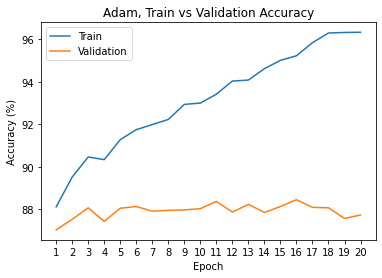

Adam Test Accuracy: 87.18001  %
Generalization Gap between Validation and Training: 8.592499 %
Generalization Gap between Test and Training: 9.152496 %
Comparing SGD with Adam: In Adam a higher max validation accuracy is achieved as well as a higher test 
accuracy, but the generalization gap between test and training is much higher in the case of Adam as 
compared to SGD. Moreover, Adam converges much faster than SGD.


In [24]:
print("Adam optimizer: Max Validation Accuracy: ",round(max(val_acc_epoch),3),"% at epoch ", val_acc_epoch.index(max(val_acc_epoch))+1)

plt.title("Adam, Train vs Validation Accuracy")
plt.plot(range(1,len(val_acc_epoch)+1),train_acc_epoch, label="Train")
plt.plot(range(1,len(val_acc_epoch)+1),val_acc_epoch, label="Validation")
plt.xticks(list(range(1,len(val_acc_epoch)+1)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(loc='best')
plt.show()

print("Adam Test Accuracy:", test_accuracy," %")
print("Generalization Gap between Validation and Training:", train_acc_epoch[-1] - val_acc_epoch[-1], "%")
print("Generalization Gap between Test and Training:", train_acc_epoch[-1] - test_accuracy, "%")
print("Comparing SGD with Adam: In Adam a higher max validation accuracy is achieved as well as a higher test \naccuracy, but the generalization gap between test and training is much higher in the case of Adam as \ncompared to SGD. Moreover, Adam converges much faster than SGD.")

Adam optimizer uses the average and uncentered variance of the gradients to update the weights instead of just using using the gradients as is like in SGD. Moreover, with Adam, as the iterations increase, a history of the gradients is retained through vk which is the exponential moving average of the gradient, where earlier gradients of previous iterations slowly get forgotten with every new iteration. Using sk which is the exponential moving average of the gradient squared the formula leads to having different learning rates for each of the weights w, if sk of a specific weight w is high(which indicates a high variance) the learning rate decreases to decrease oscillations, while if sk is low then the learning rate increases to change that specific w more to try to find the global minimum if it did not find it already.

## Early Stopping

Now, we implement the early stopping method with a patience window. All the parameters are the same as the previous section. Also, the patience window is set to 5 epochs.

In [25]:
gru_rnn3 = objax.nn.Sequential([Embed(size = max_vocab, latent = embedding_size), GRU(nin = embedding_size, nout = num_hidden_units_GRU)
    
, objax.nn.Linear(num_hidden_units_GRU, num_hidden_units), objax.functional.relu, objax.nn.Linear(num_hidden_units, 2)])

In [26]:
opt3 = objax.optimizer.Adam(gru_rnn3.vars())

In [27]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn3(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv3 = objax.GradValues(loss_function, gru_rnn3.vars())


@objax.Function.with_vars(gv3.vars() + opt3.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv3(x, y)
    opt3(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn3(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn3.vars())

In [28]:
learning_rate = 1e-3
num_epochs = 20
batch_size = 250 
max_patience_window = 5
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [29]:
# training loop
train_acc_epoch = []
val_acc_epoch = []
patience_window = 5

for epoch in range(num_epochs):
    avg_train_loss = 0 # (averaged) training loss per batch

    # shuffle the examples prior to training to remove correlation 
    train_indices = np.arange(len(messages_train)) 
    np.random.shuffle(train_indices)
    for it in range(0, messages_train.shape[0], batch_size):
        batch = train_indices[it:(it+np.minimum(batch_size,messages_train.shape[0]-it))]
        avg_train_loss += float(train_op(messages_train[batch], labels_train[batch], learning_rate)[0]) * len(batch)
    
    train_acc_epoch.append(100*accuracy(training_data))
    val_acc_epoch.append(100*accuracy(validation_data))

    if len(val_acc_epoch) >= patience_window:
      if val_acc_epoch[epoch - patience_window + 1] == max(val_acc_epoch[epoch - patience_window + 1 : epoch + 1]):
        break

test_accuracy = 100*accuracy(test_data)
print("Adam Test Accuracy:", test_accuracy, " %")

Adam Test Accuracy: 88.44001  %


Early Stopping:
Adam optimizer: Max Validation Accuracy:  88.36 % at epoch  3


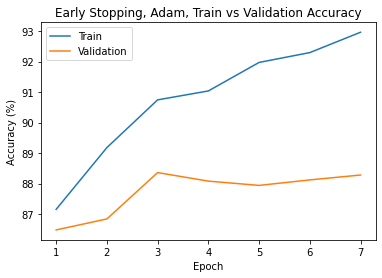

Adam Test Accuracy: 88.44001  %
Generalization Gap between Validation and Training: 4.682495 %
Generalization Gap between Test and Training: 4.5224915 %


In [30]:
print("Early Stopping:")
print("Adam optimizer: Max Validation Accuracy: ",round(max(val_acc_epoch),3),"% at epoch ", val_acc_epoch.index(max(val_acc_epoch))+1)

plt.title("Early Stopping, Adam, Train vs Validation Accuracy")
plt.plot(range(1,len(val_acc_epoch)+1),train_acc_epoch, label="Train")
plt.plot(range(1,len(val_acc_epoch)+1),val_acc_epoch, label="Validation")
plt.xticks(list(range(1,len(val_acc_epoch)+1)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(loc='best')
plt.show()

print("Adam Test Accuracy:", test_accuracy," %")
print("Generalization Gap between Validation and Training:", train_acc_epoch[-1] - val_acc_epoch[-1], "%")
print("Generalization Gap between Test and Training:", train_acc_epoch[-1] - test_accuracy, "%")

##**Best Model**

Adam achieves a higher max validation accuracy as well as a higher testing accuracy than SGD. Comparing Adam with and without early stopping we see that the early stopping has a higher test accuracy but a slightly lower max validation accuracy, moreover when using early stopping, lower generalization gaps between (validation and training) and (test and training) are achieved. The best model is chosen to be Adam with Early Stopping, having a max validation accuracy of 88.36 % and a test accuracy of 88.44001 %.